# Project 3: More Classication

## Part 1: Acquire and Partition Data (5 points)

In [35]:
import numpy as np 
import random
import matplotlib.pyplot as plt

In [11]:
# Getting the Data via Python
data   = np.loadtxt('sonar5841.dat')
# Shuffle the data
np.random.shuffle(data)
data_x = data[:,0:-1]
data_y = data[:,-1]
print('shape of data_x:',data_x.shape)
print('shape of data_y',data_y.shape)

shape of data_x: (208, 60)
shape of data_y (208,)


In [32]:
# Partitioning the Data
test_data_x = data_x[0:41]
test_data_y = data_y[0:41]

train_data_x = data_x[41:-1]
train_data_y = data_y[41:-1]

# Standardizing
# train_mean = 

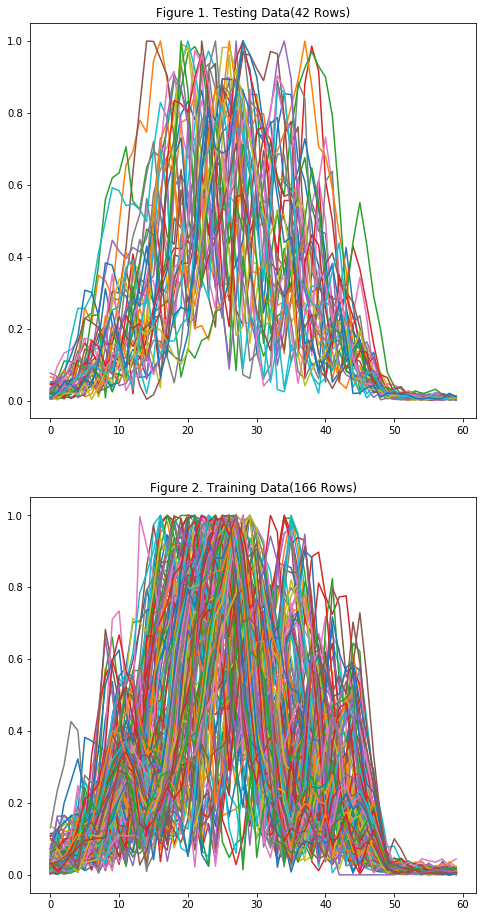

In [49]:
# Plotting
f1 = plt.figure(1, figsize=(8,16))
f1.clf()
test_data_plot  = f1.add_subplot(211)
test_data_plot.set_title("Figure 1. Testing Data(42 Rows)")
train_data_plot = f1.add_subplot(212)
train_data_plot.set_title("Figure 2. Training Data(166 Rows)")

for i in test_data_x:
    test_data_plot.plot(i)
for i in train_data_x:
    train_data_plot.plot(i)